# Fraud Prediction at Electronica 
## Part 1: Feature Engineering


This outputs a machine learning model that predicts the probability 
that the first transaction of a new user is fraudulent.

If you fail to identify a fraudulent transaction, 
Electronica loses money equivalent to the price of the fraudulently purchased product. 

If you incorrectly flag a real transaction as fraudulent, 
it inconveniences the Electronica customers whose valid transactions are flagged—a cost your client values at $8.

    Created by Edwin Campos on 2020 Feb.16
    Last modification on 2020 Feb.17 by ecampos.phd@gmail.com


In [1]:
# Clean the memory
%reset -s

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Dependencies
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Global Variables
INPUT_PATH = '/Users/ecampos/AnacondaProjects/DS-Fraud-Univar/Fraud - For Candidate/Fraud - For Candidate/'
INPUT_FILE = 'fraud.csv'
TARGET = 'class'   # Column in dataframe with target values, Fraud:1, Good:0

In [6]:
# Ingest Input dataset
df_all=pd.read_csv(INPUT_PATH+INPUT_FILE)

/Applications/anaconda/envs/Python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print(df_all.shape)
df_all.head()

(120000, 12)


,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,149671,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,15611,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,73178,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,84546,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,35978,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


## Feature Engeneering

### Do we have columns with too many missing values?

In [8]:
# Get rid of columns with too little values
print("% of missing observations:")
print(df_all.isnull().mean()*100)

% of missing observations:
Unnamed: 0        0.0
user_id           0.0
signup_time       0.0
purchase_time     0.0
purchase_value    0.0
device_id         0.0
source            0.0
browser           0.0
sex               0.0
age               0.0
ip_address        0.0
class             0.0
dtype: float64


Good! There are no missing values.

### Are there repeated values for user_id?
If so, that would mean that we are getting transactions other than the first one, which we cannot use in the model.

Recall that we should only have information about each user’s first transaction on Electronica’s website.

In [9]:
# Select all duplicate rows based on one column
df_duplicate_user_id = df_all[df_all.duplicated(['user_id'])]
print("Duplicate Rows based on user_id column are:", df_duplicate_user_id, sep='\n')

Duplicate Rows based on user_id column are:
Empty DataFrame
Columns: [Unnamed: 0, user_id, signup_time, purchase_time, purchase_value, device_id, source, browser, sex, age, ip_address, class]
Index: []


Good! There are no duplicated user_id values.

### Handle Non-Numeric values

In [10]:
df_all.dtypes

Unnamed: 0          int64
user_id             int64
signup_time        object
purchase_time      object
purchase_value     object
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

#### Convert from Dates and Times into Seconds since Epoch

In [11]:
df_all['signup_datetime'] = pd.to_datetime(df_all['signup_time'])
df_all['signup_epoch'] = (df_all['signup_datetime'] - dt.datetime(1970,1,1)).dt.total_seconds()

In [12]:
df_all['purchase_datetime'] = pd.to_datetime(df_all['purchase_time'])
df_all['purchase_epoch'] = (df_all['purchase_datetime']  - dt.datetime(1970,1,1)).dt.total_seconds()

#### Create new column features for days of week and period between signup and first purchase

In [13]:
# days_name = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
df_all['signup_dayofweek'] = df_all['signup_datetime'].dt.dayofweek
df_all['purchase_dayofweek'] = df_all['purchase_datetime'].dt.dayofweek
df_all["purchase_signup_epoch"] = (df_all['purchase_epoch'] - df_all['signup_epoch'])

In [14]:
# Unit test
df_t = pd.DataFrame({ 'my_dates':['2/16/2020 12:23','2/21/2020 4:36'] })
df_t['my_dates_datetime'] = pd.to_datetime(df_t['my_dates'])
df_t['dayofweek'] = df_t['my_dates_datetime'].dt.dayofweek
df_t['dayname'] = df_t['my_dates_datetime'].dt.weekday_name
print(df_t.head() )

          my_dates   my_dates_datetime  dayofweek dayname
0  2/16/2020 12:23 2020-02-16 12:23:00          6  Sunday
1   2/21/2020 4:36 2020-02-21 04:36:00          4  Friday


#### Convert to purchase_value and age into numeric type

In [15]:
# Removing Non-Word Characters (% @ " ? % $) using Regular Expressions
# One can group multiple patterns to match or substitute in a string using the square bracket. 
df_all['purchase_value_numeric'] = df_all['purchase_value'].replace(r"[@\'?\$%_]", "", regex=True).apply(pd.to_numeric, errors='raise')

In [16]:
# Unit test
print('Input data: ', 
      df_all.purchase_value[586], 
      df_all.purchase_value[119999])
print('Output data: ',
      df_all.purchase_value_numeric[586], 
      df_all.purchase_value_numeric[119999])
print('Correct answer: 77  32')

Input data:  $77  32
Output data:  77 32
Correct answer: 77  32


#### Apply One-Hot-Encoding to columns source, browser, and sex

In [17]:
# It's most common to one-hot encode these "object" columns, since they can't be plugged directly into most models. 
# Pandas offers a convenient function called get_dummies to get one-hot encodings.
onehotencoding_columns = ['source', 'browser', 'sex']  # On column 'source', SEO corresponds to Search Engine Optimization
for col in onehotencoding_columns:
    df_dummies = pd.get_dummies(df_all[col], prefix = 'category')
    df_all = pd.concat([df_all, df_dummies], axis=1)

#### Convert ip_address into country and then into classes (with one-hot-encoding)

In [18]:
df_all.dtypes

Unnamed: 0                         int64
user_id                            int64
signup_time                       object
purchase_time                     object
purchase_value                    object
device_id                         object
source                            object
browser                           object
sex                               object
age                                int64
ip_address                       float64
class                              int64
signup_datetime           datetime64[ns]
signup_epoch                     float64
purchase_datetime         datetime64[ns]
purchase_epoch                   float64
signup_dayofweek                   int64
purchase_dayofweek                 int64
purchase_signup_epoch            float64
purchase_value_numeric             int64
category_Ads                       uint8
category_Direct                    uint8
category_SEO                       uint8
category_Chr0me                    uint8
category_Chrome 

#### Identify features and target columns

In [19]:
unwanted_columns = ['signup_time', 'purchase_time',
                    'purchase_value', 'device_id', 
                    'source', 'browser','sex',
                    'signup_datetime', 'purchase_datetime']
unwanted_columns.append(TARGET)
feature_columns =[x for x in df_all.columns if x not in unwanted_columns]
X_train = df_all[feature_columns]
y_train = df_all[TARGET]
print('Model Features:', feature_columns)
print('Model Target:', TARGET)

Model Features: ['Unnamed: 0', 'user_id', 'age', 'ip_address', 'signup_epoch', 'purchase_epoch', 'signup_dayofweek', 'purchase_dayofweek', 'purchase_signup_epoch', 'purchase_value_numeric', 'category_Ads', 'category_Direct', 'category_SEO', 'category_Chr0me', 'category_Chrome', 'category_FireFox', 'category_IE', 'category_Opera', 'category_Safari', 'category_F', 'category_M']
Model Target: class


In [20]:
print(X_train.shape)
X_train.describe()

(120000, 21)


,Unnamed: 0,user_id,age,ip_address,signup_epoch,purchase_epoch,signup_dayofweek,purchase_dayofweek,purchase_signup_epoch,purchase_value_numeric,...,category_Direct,category_SEO,category_Chr0me,category_Chrome,category_FireFox,category_IE,category_Opera,category_Safari,category_F,category_M
count,120000.000000,120000.000000,120000.000000,1.200000e+05,1.200000e+05,1.200000e+05,120000.000000,120000.000000,1.200000e+05,120000.000000,...,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,75639.133600,200320.280100,33.125250,2.151550e+09,1.429498e+09,1.434431e+09,3.023633,3.016808,4.933112e+06,36.881475,...,0.202017,0.402475,0.000025,0.405408,0.163458,0.242817,0.024792,0.163500,0.415617,0.584383
std,43619.702878,115361.945935,8.617081,1.248314e+09,5.927233e+06,7.040612e+06,2.006533,2.006733,3.127784e+06,18.325855,...,0.401506,0.490399,0.005000,0.490973,0.369785,0.428787,0.155490,0.369823,0.492830,0.492830
min,1.000000,2.000000,18.000000,9.344714e+04,1.420070e+09,1.420070e+09,0.000000,0.000000,0.000000e+00,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37867.750000,100925.500000,27.000000,1.085345e+09,1.424273e+09,1.429372e+09,1.000000,1.000000,2.188140e+06,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75703.000000,200037.500000,33.000000,2.155238e+09,1.429422e+09,1.434642e+09,3.000000,3.000000,4.924380e+06,34.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,113417.250000,300395.500000,39.000000,3.241268e+09,1.434638e+09,1.439840e+09,5.000000,5.000000,7.648215e+06,49.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,151112.000000,400000.000000,76.000000,4.294850e+09,1.439872e+09,1.450235e+09,6.000000,6.000000,1.036794e+07,154.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Visualize Input Dataset

In [21]:
%matplotlib inline
sns.set(style='ticks')

In [22]:
# Pandas dataframe with model features and model target
DF = pd.concat([X_train, y_train], axis=1)

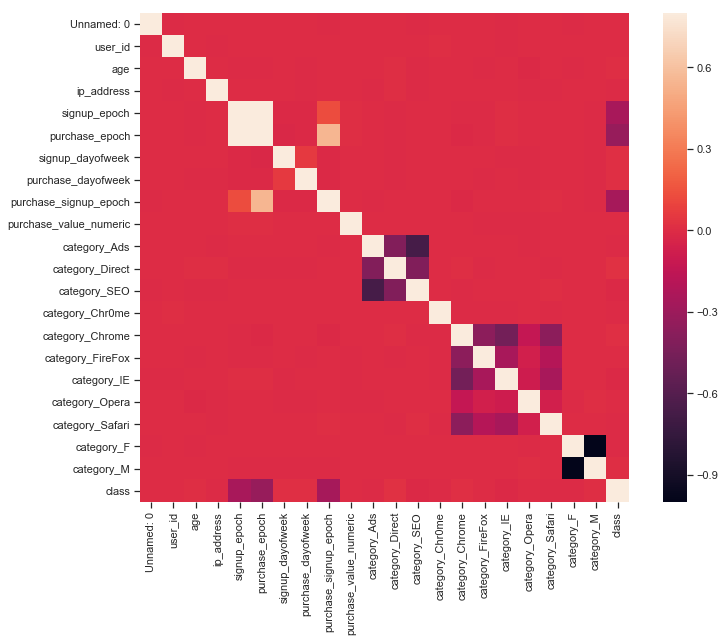

In [23]:
# Compute and visualize covariance (correlation) matrix
correl_matrix = DF.corr()
fig = plt.figure(figsize = (12,9))
sns.heatmap(correl_matrix, vmax=0.8, square=True)
plt.show()

#### How unbalanced is the target data?

In [24]:
def plot_balance(dataseries_name, plot_title, percent=True):
    """Generates a bar plot with the counts of frauds and no-frauds events.
    Arguments:
    dataseries_name: Pandas series with the target dataset 
                    For example 'ds'
    plot_title: For example 'Synthetic Unbalanced Dataset'
    """
    if percent:
        percent_values = dataseries_name.value_counts(normalize=True).mul(100).round(1)
        sns.barplot([0,1], percent_values)
        y_label = 'Percent'
    else:
        sns.barplot([0,1], dataseries_name.value_counts().values)
        y_label = 'Count'
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(TARGET+' (0:Good, 1:Fraud)')

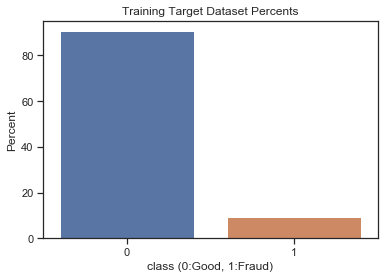

In [25]:
plot_balance(y_train, 'Training Target Dataset Percents')

In [26]:
# Show how unbalanced is the Target data
counts = y_train.value_counts()
perc = y_train.value_counts(normalize=True).mul(100).round(1)
pd.DataFrame({'counts': counts, 'percents': perc})

,counts,percents
0,108735,90.6
1,11265,9.4


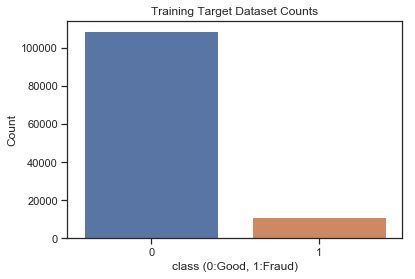

In [27]:
plot_balance(y_train, 'Training Target Dataset Counts', percent=False)

### Prove that the features can be used on a Machine Learning algorithm

#### Using Class-weighted Logistic Regression

Reference: https://machinelearningmastery.com/cost-sensitive-logistic-regression/

In [42]:
#import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [50]:
weights = {0:9.0, 1:91.0}  # As best practice, use inverse of class distribution present in training dataset.
model_logistic_reg = LogisticRegression(solver='lbfgs', 
                                        class_weight=weights)

In [51]:
model_logistic_reg.fit(X_train, y_train)

print('Weights:', weights)
print(classification_report(y_train, 
                            model_logistic_reg.predict(X_train)
                           ))

Weights: {0: 9.0, 1: 91.0}
              precision    recall  f1-score   support

           0       0.95      0.62      0.75    108735
           1       0.16      0.71      0.27     11265

   micro avg       0.63      0.63      0.63    120000
   macro avg       0.56      0.67      0.51    120000
weighted avg       0.88      0.63      0.71    120000



In [48]:
from sklearn.utils.class_weight import compute_class_weight
# calculate class weighting
weighting = compute_class_weight('balanced', [0,1], y_train)
print('compute_class_weight:', weighting)

weights = {0:weighting[0], 1:weighting[1]}
model_logistic_reg = LogisticRegression(solver='lbfgs', 
                                        class_weight=weights)

model_logistic_reg.fit(X_train, y_train)

print(classification_report(y_train, 
                            model_logistic_reg.predict(X_train)
                           ))

compute_class_weight: [0.55180025 5.32623169]
              precision    recall  f1-score   support

           0       0.95      0.64      0.77    108735
           1       0.17      0.70      0.27     11265

   micro avg       0.65      0.65      0.65    120000
   macro avg       0.56      0.67      0.52    120000
weighted avg       0.88      0.65      0.72    120000



#### Grid Search

In [54]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [56]:
# define model
model_logistic_reg = LogisticRegression(solver='lbfgs')
# define grid
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.765200 using {'class_weight': {0: 100, 1: 1}}
0.765200 (0.008464) with: {'class_weight': {0: 100, 1: 1}}
0.765110 (0.008482) with: {'class_weight': {0: 10, 1: 1}}
0.764770 (0.008500) with: {'class_weight': {0: 1, 1: 1}}
0.763416 (0.008543) with: {'class_weight': {0: 1, 1: 10}}
0.760245 (0.008561) with: {'class_weight': {0: 1, 1: 100}}


In [ ]:
# Using Naive Bayes

#### Compute Cross Validation

In [45]:
from sklearn.model_selection import cross_val_score

In [46]:
MODEL = model_logistic_reg
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(MODEL, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

NameError: name 'RepeatedStratifiedKFold' is not defined

The code below is using Class Weighted XGBoost, or Cost-Sensitive XGBoost, which can offer better performance on binary classification problems with a severe class imbalance.

Reference: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
# Instantiate the XGBClassifier: xg_cl
xg_cl = XGBClassifier(objective='binary:logistic', n_estimators=10, seed=21)

# Fit the classifier to the training set
xg_cl.fit(X_train, y_train)

# Predict the labels of the test set: preds
predic = xg_cl.predict(X_test)
probab = xg_cl.predict_proba(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(predic==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

In [ ]:
POR ACA VOY
# Define model: eXtreame Gradient Boosting
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, # Number of folds
                             n_repeats=3, # Number of times cross-validator will be repeated
                             random_state=1)  # For reproducible results
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

#### Using stratified cross validation to evaluate an XGBoost model.

If you have many classes for a classification type predictive modeling problem or the classes are imbalanced (there are a lot more instances for one class than another), it can be a good idea to create stratified folds when performing cross validation.

This has the effect of enforcing the same distribution of classes in each fold as in the whole training dataset when performing the cross validation evaluation. The scikit-learn library provides this capability in the StratifiedKFold class.

Reference: https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/

In [ ]:
# Define evaluation method: stratified k-fold cross validation evaluation of xgboost model
#from numpy import loadtxt
#import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
# Cross Validated model
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#### Create a Cost Function to assess the model performance

Note that if the model fails to identify a fraudulent transaction, 
Electronica loses money equivalent to the price of the fraudulently purchased product. 

If the model incorrectly flags a real transaction as fraudulent, 
it inconveniences the Electronica customers whose valid transactions are flagged—a cost your client values at $8.
